Numero di componenti per il 90% di varianza: 7


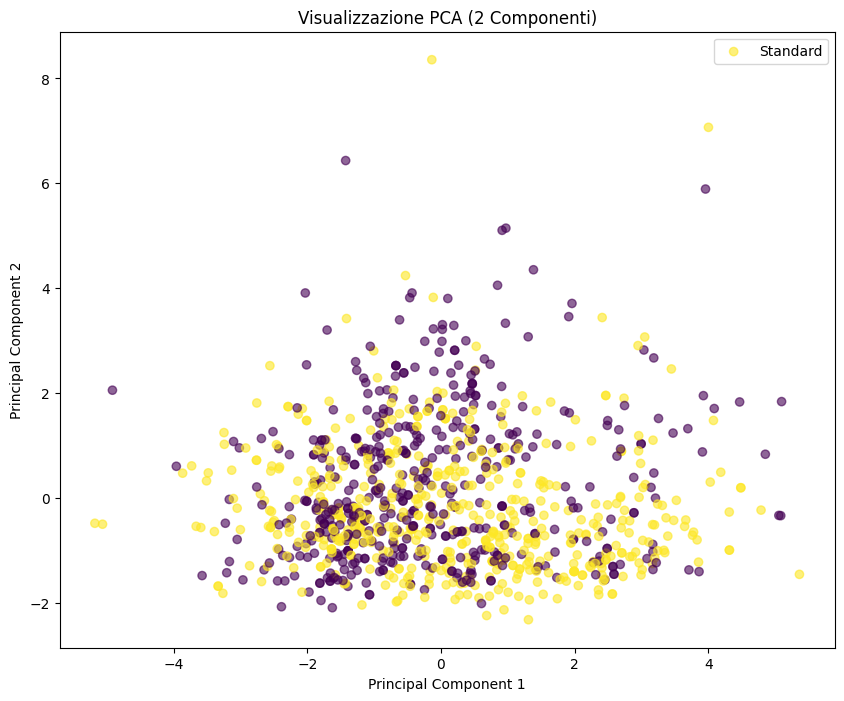

Best Regression Model: Ridge(alpha=10.0)
Test MSE: 0.7990863881249252
Test MAE: 0.7172951374676192
SVR Test MSE: 0.46414373770477046
SVR Test MAE: 0.5125372515699639

Confronto Modelli (Validation Set):
                      Accuracy  Precision    Recall  F1-Score
MLP (Neural Network)  0.648438   0.662069  0.700730  0.680851
SVM                   0.714844   0.728571  0.744526  0.736462

Modello Selezionato: SVM

Valutazione delle prestazioni Modello Selezionato (Test Set):
     Accuracy  Precision    Recall  F1-Score
SVM   0.70625   0.748387  0.678363  0.711656

Confronto Speculativo (Test Set):
                      Accuracy  Precision    Recall  F1-Score
MLP (Neural Network)   0.68750   0.705202  0.713450  0.709302
SVM                    0.70625   0.748387  0.678363  0.711656


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score

df = pd.read_csv("/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv") 

df = df.dropna() 

y_reg = df['alcohol'].copy() 

df['quality_binary'] = df['quality'].apply(lambda x: 0 if 3 <= x <= 5 else 1) 
y_cls = df['quality_binary'].copy() 

X = df.drop(['alcohol', 'quality', 'quality_binary'], axis=1) 

X_train_full, X_test, y_reg_train_full, y_reg_test, y_cls_train_full, y_cls_test = train_test_split( 
    X, y_reg, y_cls, test_size=0.20, random_state=42, stratify=y_cls 
)

X_train, X_val, y_reg_train, y_reg_val, y_cls_train, y_cls_val = train_test_split(
    X_train_full, y_reg_train_full, y_cls_train_full, test_size=0.20, random_state=42, stratify=y_cls_train_full
)

scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val) 
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train_scaled) 
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

k_components = pca.n_components_ 
print(f"Numero di componenti per il 90% di varianza: {k_components}")

pca_vis = PCA(n_components=2) 
X_train_vis = pca_vis.fit_transform(X_train_scaled) 

plt.figure(figsize=(10, 8)) 
scatter = plt.scatter(X_train_vis[:, 0], X_train_vis[:, 1], c=y_cls_train, alpha=0.6)  
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(labels=['Standard', 'Ottimo'])
plt.title('Visualizzazione PCA (2 Componenti)')
plt.show()

reg_params = {'alpha': [0.1, 1.0, 10.0]} 
reg_model = Ridge()
reg_grid = GridSearchCV(reg_model, reg_params, cv=5, scoring='neg_mean_squared_error') 
reg_grid.fit(X_train_pca, y_reg_train)

best_reg_model = reg_grid.best_estimator_ 
y_reg_pred = best_reg_model.predict(X_test_pca) 

mse_reg = mean_squared_error(y_reg_test, y_reg_pred) 
mae_reg = mean_absolute_error(y_reg_test, y_reg_pred) 

print(f"Best Regression Model: {best_reg_model}")
print(f"Test MSE: {mse_reg}")
print(f"Test MAE: {mae_reg}")

svr = SVR() 
svr.fit(X_train_pca, y_reg_train) 
y_svr_pred = svr.predict(X_test_pca)
print(f"SVR Test MSE: {mean_squared_error(y_reg_test, y_svr_pred)}") 
print(f"SVR Test MAE: {mean_absolute_error(y_reg_test, y_svr_pred)}") 

mlp_params = { 
    'hidden_layer_sizes': [(50,), (100,), (50, 50)], 
    'activation': ['relu', 'tanh'],
    'solver': ['adam'], 
    'alpha': [0.0001, 0.001], 
    'learning_rate_init': [0.001, 0.01] 
}

mlp = MLPClassifier(max_iter=2000, early_stopping=True, random_state=42)
mlp_grid = GridSearchCV(mlp, mlp_params, cv=3, scoring='f1') 
mlp_grid.fit(X_train_pca, y_cls_train) 

svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['auto']
}

svm = SVC(random_state=42) 
svm_grid = GridSearchCV(svm, svm_params, cv=3, scoring='f1')  
svm_grid.fit(X_train_pca, y_cls_train) 

def evaluate_model(model, X, y): 
    pred = model.predict(X)
    return {
        'Accuracy': accuracy_score(y, pred),
        'Precision': precision_score(y, pred),
        'Recall': recall_score(y, pred),
        'F1-Score': f1_score(y, pred)
    }

mlp_val_metrics = evaluate_model(mlp_grid.best_estimator_, X_val_pca, y_cls_val)
svm_val_metrics = evaluate_model(svm_grid.best_estimator_, X_val_pca, y_cls_val)

comparison_df = pd.DataFrame([mlp_val_metrics, svm_val_metrics], index=['MLP (Neural Network)', 'SVM']) 
print("\nConfronto Modelli (Validation Set):")
print(comparison_df)

best_model_name = comparison_df['F1-Score'].idxmax() 
if best_model_name == 'MLP (Neural Network)':
    final_model = mlp_grid.best_estimator_
else:
    final_model = svm_grid.best_estimator_

print(f"\nModello Selezionato: {best_model_name}")

final_test_metrics = evaluate_model(final_model, X_test_pca, y_cls_test) 
print("\nValutazione delle prestazioni Modello Selezionato (Test Set):")
print(pd.DataFrame([final_test_metrics], index=[best_model_name])) 

mlp_test_metrics = evaluate_model(mlp_grid.best_estimator_, X_test_pca, y_cls_test) 
svm_test_metrics = evaluate_model(svm_grid.best_estimator_, X_test_pca, y_cls_test) 

speculative_df = pd.DataFrame([mlp_test_metrics, svm_test_metrics], index=['MLP (Neural Network)', 'SVM']) 
print("\nConfronto Speculativo (Test Set):")
print(speculative_df)